In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import plotly.graph_objects as go   

data1 = pd.read_csv('data1.csv')
X, y = np.array(data1.iloc[:, :-1]), np.array(data1.iloc[:, -1:])

## 1.1
Na wykresach możemy dostrzec prawdopodobną wysoką korelację liniową, którą zaburza nam jeden outlier w okolicach x ~= (-500, 250). 

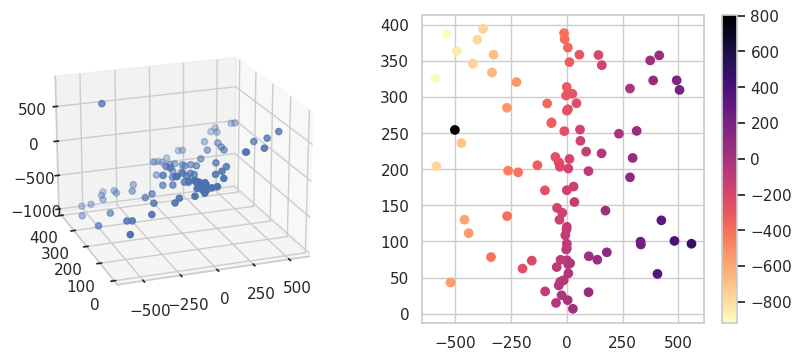

In [2]:
def plot_3d_data(X, y):    
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=y[:, 0])
    ax.view_init(azim=250, elev=20)

    ax = fig.add_subplot(122, projection=None)
    scatters = ax.scatter(x=X[:, 0], y=X[:, 1], c=y[:, 0], cmap='magma_r')
    plt.colorbar(scatters)

plot_3d_data(X, y)

## 1.2
Aby pozbyć się outlierów normalizujemy dane do $\mu$ = 0 i $\sigma$ = 1 i usuwamy wszystkie dane z wartościami powyżej 3 $\sigma$.

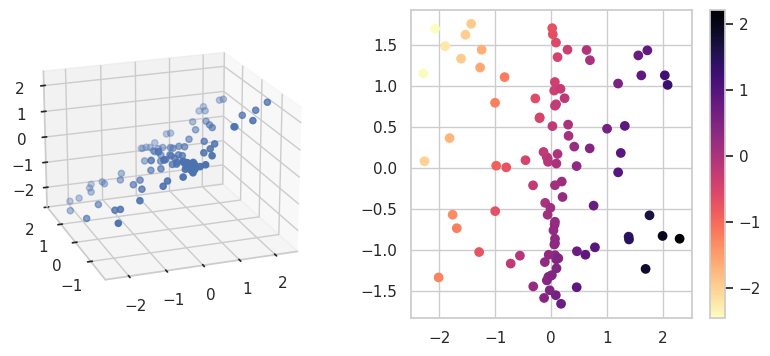

In [3]:
def z_score(x): 
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def preprocess_data(X: pd.DataFrame, y: pd.DataFrame):
    X, y = z_score(X), z_score(y)
    idx = (X < 3).all(1) & (y < 3).all(1)
    return X[idx], y[idx]

plot_3d_data(*preprocess_data(X, y))

In [4]:
X_p, y_p = preprocess_data(X, y)
lm = LinearRegression().fit(X_p, y_p)

x_surf, y_surf = np.meshgrid(
    np.linspace(X_p[:, 0].min(), X_p[:, 0].max(), 50),
    np.linspace(X_p[:, 1].min(), X_p[:, 1].max(), 50)
)
z_surf = lm.intercept_ + lm.coef_[0, 0] * x_surf + lm.coef_[0, 1] * y_surf
surface = go.Surface(x=x_surf, y=y_surf, z=z_surf)

scatters = go.Scatter3d(
    x=X_p[:, 0], y=X_p[:, 1], z=y_p[:, 0], 
    mode='markers', 
    marker=dict(size=3)
)

fig = go.Figure([scatters, surface])
fig.update_layout(width=700, height=600)
fig.show()

## 2.1, 2.2 i 2.3
Do podziału danych proponuję walidację krzyżową K-Fold. Dzielimy dane na 5 części i po kolei testujemy model na każdej z nich, reszty używając do treningu. 

Nasz model baseline'owy zwraca średnią z x'ów.

In [5]:
def nmse(pred, true):
    return np.mean((true - pred)**2) / np.array(true).var()

def test_model(model, X, y, prep_fn=lambda X, y: (X, y)):    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    error = 0.0
    
    for train_idx, test_idx in kfold.split(X):
        X_train, y_train = prep_fn(X[train_idx], y[train_idx])
        X_test, y_test = prep_fn(X[test_idx], y[test_idx])
        
        lm = model.fit(X_train, y_train)
        error += nmse(lm.predict(X_test), y_test)
        
    return error / 5

class Baseline:
    def fit(self, X, y): return self
    def predict(self, x): 
        x = np.array(x)
        return np.mean(x, axis=1, keepdims=True)

error_b = test_model(Baseline(), X, y)
print(f"Baseline NMSE: {error_b:.4f}")

error_bp = test_model(Baseline(), X, y, preprocess_data)
print(f"Baseline NMSE with preprocessing: {error_bp:.4f}")

Baseline NMSE: 1.7642
Baseline NMSE with preprocessing: 1.1961


## 2.3 i 2.4
Regresja liniowa sprawuje się o wiele lepiej niż model baseline'owy, a dodatkowy preprocessing (normalizacja + usuwanie outlierów) poprawia wyniki ponad 7-krotnie. 

In [6]:
error = test_model(LinearRegression(), X, y)
print(f"NMSE without preprocessing: {error:.4f}")

error_p = test_model(LinearRegression(), X, y, preprocess_data)
print(f"NMSE with preprocessing: {error_p:.4f}")

NMSE without preprocessing: 0.3726
NMSE with preprocessing: 0.0539


## 2.5

In [7]:
pd.DataFrame(
    [[error, error_b], 
     [error_p, error_bp]],
    index=pd.Index([False, True], name='Preprocessing'),
    columns=pd.Index(['Regression', 'Baseline'], name='Model')
)

Model,Regression,Baseline
Preprocessing,,
False,0.372561,1.764205
True,0.053914,1.196062
